<a href="https://colab.research.google.com/github/amarie-51/projekt_NLP/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import re

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
tags_poprawne=pd.read_csv('/content/test_set_only_tags.txt', header = None)
tweets=open('/content/test_set_only_text.txt')
table_of_tweets=[]
for line in tweets.readlines():
  table_of_tweets.append(line)

tags_poprawne.columns=["label"]
tweets=pd.DataFrame(table_of_tweets)
tweets.columns=["Tweet"]
df_tweets=pd.concat([tweets,tags_poprawne],axis=1)

In [3]:
df_tweets.loc[:,"Tweet"] = df_tweets.Tweet.apply(lambda x : str.lower(x))
df_tweets.loc[:,"Tweet"] = df_tweets.Tweet.apply(lambda x : " ".join(re.findall('[\w]+',x)))

In [4]:
print(df_tweets.head)

<bound method NDFrame.head of                                                  Tweet  label
0    anonymized_account spoko jak im duda z morawie...      0
1    anonymized_account anonymized_account ale on t...      0
2    anonymized_account no czy prezes nie miał racj...      0
3    anonymized_account anonymized_account przecież...      0
4    anonymized_account anonymized_account owszem p...      0
..                                                 ...    ...
995  anonymized_account olej jak kto sie ubiera pat...      0
996  anonymized_account to oczywiste byłyście dziś ...      0
997  anonymized_account duda może się przyjąć w bia...      0
998  anonymized_account ty jesteś jebnięty tła taki...      2
999  anonymized_account anonymized_account ale to n...      0

[1000 rows x 2 columns]>


In [6]:
with open("/content/stop_words.txt", "r") as stop_words:
	lines = stop_words.read().splitlines()


stop_words=lines
def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

df_tweets.loc[:,"Tweet"] = df_tweets.Tweet.apply(lambda x: remove_stopWords(x))

In [7]:
df_tweets["Tokeny"]=df_tweets["Tweet"]
df_tweets['Tokeny'] = df_tweets.apply(lambda row: nltk.word_tokenize(row['Tweet']), axis=1)
print(df_tweets.columns)

Index(['Tweet', 'label', 'Tokeny'], dtype='object')


In [8]:
df_neutral=df_tweets.loc[df_tweets["label"]==0].reset_index()
df_cyberbullying=df_tweets.loc[df_tweets["label"]==1].reset_index()
df_hatespeech=df_tweets.loc[df_tweets["label"]==2].reset_index()

In [9]:
def word_cloud(data):
  all_words = ' '.join([text for text in data ])
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()


In [ ]:
df_bad=df_tweets.loc[(df_tweets["label"]==1) |(df_tweets["label"]==2)]
print(df_bad.head
      )

In [ ]:
print("Tweety neutralne")
#word_cloud(df_neutral["Tweet"])
print(df_neutral.head)

print("Tweety cyberbullying")
#word_cloud(df_cyberbullying["Tweet"])
print(df_cyberbullying.head)

print("Tweety hate-speech")
#word_cloud(df_hatespeech["Tweet"])
print(df_hatespeech.head)

Downsampling/oversampling

In [12]:
df_random_neutral=df_neutral.sample(n=400)
df_tweets=pd.concat([df_random_neutral,df_hatespeech,df_hatespeech,df_cyberbullying,df_cyberbullying,df_cyberbullying,df_cyberbullying])


# Sieć neuronowa

podział na dwa datasety

In [67]:
from sklearn.preprocessing import OneHotEncoder #tutaj chciałam zrobi output wektor
from sklearn.preprocessing import LabelBinarizer
Y = pd.get_dummies(df_tweets.label)

print(Y)

     0  1  2
760  1  0  0
114  1  0  0
483  1  0  0
617  1  0  0
391  1  0  0
..  .. .. ..
20   0  1  0
21   0  1  0
22   0  1  0
23   0  1  0
24   0  1  0

[718 rows x 3 columns]


In [68]:
from sklearn.model_selection import train_test_split
tweets = df_tweets['Tweet'].values
label= Y.values

tweets_train, tweets_test, label_train, label_test = train_test_split(tweets, label, test_size=0.2, shuffle=True)



lemmatyzacja

In [ ]:
!pip install --upgrade spacy

In [ ]:
!sudo python -m spacy download pl_core_news_sm

In [69]:
import spacy
from spacy.lang.pl.stop_words import STOP_WORDS as stop_words_spacy

nlp=spacy.load('pl_core_news_sm')

In [70]:
def lemmatize(comments: list, nlp: spacy) -> list:
  
  def is_redundant(token):
    return any([token.is_punct, token.is_stop, token.is_space])

  return [' '.join([token.lemma_ for token in nlp(comment) if not is_redundant(token)]) for comment in comments]

In [71]:
tweets_test=lemmatize(tweets_test, nlp)
tweets_train = lemmatize(tweets_train, nlp)

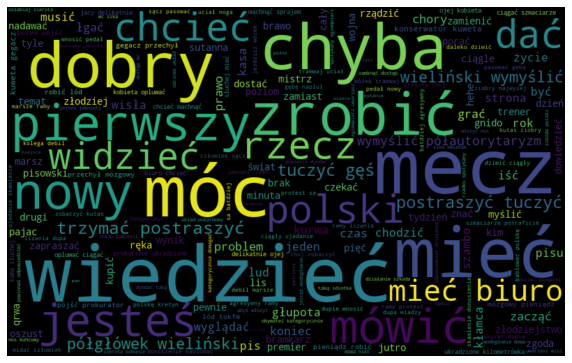

In [72]:
word_cloud(tweets_train)

tworzymy wektory z tweetów

In [73]:
import numpy as np
import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import matplotlib.pyplot 


wektoryzacja

In [74]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(tweets_train)

X_train = vectorizer.transform(tweets_train)
X_test  = vectorizer.transform(tweets_test)

tworzenie modelu sieci neuronowej

In [76]:
import numpy as np
import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [75]:
model= Sequential([
                   Dense(64,activation="relu"),
                   Dropout(0.5),
                   Dense(64,activation="relu"),
                   Dense(units=3, activation="softmax")
])
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])


In [79]:
model.build(X_train.shape)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (574, 64)                 112064    
_________________________________________________________________
module_wrapper_13 (ModuleWra (574, 64)                 0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (574, 64)                 4160      
_________________________________________________________________
module_wrapper_15 (ModuleWra (574, 3)                  195       
Total params: 116,419
Trainable params: 116,419
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_3/module_wrapper_12/dense_9/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_3/module_wrapper_12/dense_9/embedding_lookup_sparse/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_3/module_wrapper_12/dense_9/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


72/72 [==============================] - 1s 6ms/step - loss: 1.0458 - accuracy: 0.5334 - val_loss: 0.9048 - val_accuracy: 0.6111
Epoch 2/10
72/72 [==============================] - 0s 3ms/step - loss: 0.8520 - accuracy: 0.5844 - val_loss: 0.7173 - val_accuracy: 0.7014
Epoch 3/10
72/72 [==============================] - 0s 3ms/step - loss: 0.6080 - accuracy: 0.7465 - val_loss: 0.4442 - val_accuracy: 0.8403
Epoch 4/10
72/72 [==============================] - 0s 3ms/step - loss: 0.2733 - accuracy: 0.9514 - val_loss: 0.2635 - val_accuracy: 0.9028
Epoch 5/10
72/72 [==============================] - 0s 3ms/step - loss: 0.1171 - accuracy: 0.9807 - val_loss: 0.2015 - val_accuracy: 0.9236
Epoch 6/10
72/72 [==============================] - 0s 3ms/step - loss: 0.0372 - accuracy: 0.9993 - val_loss: 0.1808 - val_accuracy: 0.9236
Epoch 7/10
72/72 [==============================] - 0s 3ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.1726 - val_accuracy: 0.9167
Epoch 8/10
72/72 [=============

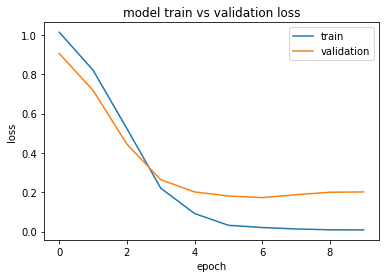

In [81]:
import matplotlib.pyplot as pyplot
history= model.fit(X_train,label_train, validation_data=(X_test,label_test), batch_size=8, epochs=10)
#, validation_data=(X_test,label_test)
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Sprawdzanie modelu

In [88]:
y_pred=model.predict(X_test)
print(y_pred[:20])

y_pred=np.round(y_pred)


[[1.6518210e-03 9.9819309e-01 1.5506340e-04]
 [9.9632877e-01 1.5476953e-03 2.1235247e-03]
 [3.8570005e-02 2.4152017e-04 9.6118850e-01]
 [9.9371296e-01 2.2437542e-03 4.0433281e-03]
 [9.9718338e-01 3.3990719e-04 2.4767458e-03]
 [9.9906701e-01 6.0256588e-04 3.3045624e-04]
 [2.2403703e-05 3.5772138e-07 9.9997723e-01]
 [9.9454826e-01 1.4838437e-04 5.3032832e-03]
 [9.4532812e-01 8.6241877e-03 4.6047661e-02]
 [9.9996459e-01 2.8669525e-05 6.6308430e-06]
 [9.9398875e-01 1.2128203e-03 4.7984789e-03]
 [9.9998939e-01 7.7108543e-06 2.9124656e-06]
 [2.2331970e-03 5.6534755e-04 9.9720144e-01]
 [9.7369087e-01 1.0373631e-03 2.5271771e-02]
 [9.8454827e-01 4.6311449e-03 1.0820513e-02]
 [9.9156219e-01 1.7811755e-03 6.6565732e-03]
 [1.1066587e-02 2.8706141e-04 9.8864639e-01]
 [9.9716741e-01 1.0354226e-03 1.7972615e-03]
 [4.3388270e-04 9.9942505e-01 1.4100900e-04]
 [9.9847192e-01 1.0566975e-03 4.7135536e-04]]


In [89]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [ ]:
plot_history(history) 

In [ ]:
print(y_pred[:10])
print(label_test[:10])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(label_test,y_pred))